In [37]:
# ライブラリをインポート

# データ操作と数値計算のため
import pandas as pd
import numpy as np

# データ可視化のため
import matplotlib.pyplot as plt
import seaborn as sns

# 統計モデリングと計量経済分析のため
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# for ignore warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
url = "https://www.fbc.keio.ac.jp/~tyabu/keiryo/var_stockprice_data.csv"
df = pd.read_csv(url)
df.head()

,date,time,Dow,Nikkei
0,2010/1/5,1,-0.112812,0.253783
1,2010/1/6,2,0.015702,0.464527
2,2010/1/7,3,0.313798,-0.463963
3,2010/1/8,4,0.106818,1.092152
4,2010/1/12,5,0.085419,0.748450


## 15.3.2節の推定結果

In [11]:
# VARモデルの選択
model = VAR(df[['Dow', 'Nikkei']])
var_select = model.select_order(maxlags=12)
print(var_select.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.4123      0.4176       1.510      0.4142
1       0.1453     0.1614*       1.156      0.1512
2       0.1390      0.1657       1.149     0.1488*
3       0.1395      0.1768       1.150      0.1531
4      0.1380*      0.1860      1.148*      0.1556
5       0.1398      0.1985       1.150      0.1613
6       0.1417      0.2111       1.152      0.1671
7       0.1442      0.2243       1.155      0.1735
8       0.1471      0.2379       1.158      0.1803
9       0.1436      0.2451       1.154      0.1808
10      0.1432      0.2553       1.154      0.1842
11      0.1444      0.2672       1.155      0.1894
12      0.1454      0.2789       1.156      0.1942
--------------------------------------------------


### p = 4 としたVARとグレンジャーの因果性検定

In [15]:
# ラグ変数の作成
df_data_lagged = df.copy()  # データフレームをコピー
df_data_lagged['lag1_dow'] = df_data_lagged['Dow'].shift(1)
df_data_lagged['lag2_dow'] = df_data_lagged['Dow'].shift(2)
df_data_lagged['lag3_dow'] = df_data_lagged['Dow'].shift(3)
df_data_lagged['lag4_dow'] = df_data_lagged['Dow'].shift(4)
df_data_lagged['lag1_nikkei'] = df_data_lagged['Nikkei'].shift(1)
df_data_lagged['lag2_nikkei'] = df_data_lagged['Nikkei'].shift(2)
df_data_lagged['lag3_nikkei'] = df_data_lagged['Nikkei'].shift(3)
df_data_lagged['lag4_nikkei'] = df_data_lagged['Nikkei'].shift(4)
df_data_lagged = df_data_lagged.dropna()  # 欠損値を含む行を除去

# データの確認
print(df_data_lagged.head())

        date       Dow    Nikkei  lag1_dow  lag2_dow  lag3_dow  lag4_dow  \
4 2010-01-12  0.085419  0.748450  0.106818  0.313798  0.015702 -0.112812   
5 2010-01-13  0.503516 -1.324645  0.085419  0.106818  0.313798  0.015702   
6 2010-01-14  0.278819  1.608286  0.503516  0.085419  0.106818  0.313798   
7 2010-01-15 -0.942062  0.682272  0.278819  0.503516  0.085419  0.106818   
8 2010-01-19  1.091271 -1.977764 -0.942062  0.278819  0.503516  0.085419   

   lag1_nikkei  lag2_nikkei  lag3_nikkei  lag4_nikkei  
4     1.092152    -0.463963     0.464527     0.253783  
5     0.748450     1.092152    -0.463963     0.464527  
6    -1.324645     0.748450     1.092152    -0.463963  
7     1.608286    -1.324645     0.748450     1.092152  
8     0.682272     1.608286    -1.324645     0.748450  


### 回帰分析

In [20]:
# 説明変数と目的変数を設定
X = df_data_lagged[['lag1_nikkei', 'lag2_nikkei', 'lag3_nikkei', 'lag4_nikkei', 'lag1_dow', 'lag2_dow', 'lag3_dow', 'lag4_dow']]
y = df_data_lagged['Nikkei']

# 定数項を追加
X = sm.add_constant(X)

# 回帰モデルの適用
model_Nikkei = sm.OLS(y, X).fit(cov_type='HC1')  # ロバスト標準誤差を使用

# 結果の表示
print(model_Nikkei.summary())


                            OLS Regression Results                            
Dep. Variable:                 Nikkei   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     58.13
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           5.91e-86
Time:                        22:53:44   Log-Likelihood:                -3409.2
No. Observations:                2128   AIC:                             6836.
Df Residuals:                    2119   BIC:                             6887.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0092      0.027      0.346      

### F検定

In [28]:
f_test_result_Nikkei = model_Nikkei.f_test(["lag1_dow = 0", "lag2_dow = 0", "lag3_dow = 0", "lag4_dow = 0"])
print(f_test_result_Nikkei)

<F test: F=109.39353079025189, p=7.63076757596427e-85, df_denom=2.12e+03, df_num=4>


In [29]:
# 説明変数と目的変数を設定
X_Dow = df_data_lagged[['lag1_nikkei', 'lag2_nikkei', 'lag3_nikkei', 'lag4_nikkei', 'lag1_dow', 'lag2_dow', 'lag3_dow', 'lag4_dow']]
y_Dow = df_data_lagged['Dow']

# 定数項を追加
X_Dow = sm.add_constant(X_Dow)

# 回帰モデルの適用
model_Dow = sm.OLS(y_Dow, X_Dow).fit(cov_type='HC1')  # ロバスト標準誤差を使用

# 結果の表示
print(model_Dow.summary())


                            OLS Regression Results                            
Dep. Variable:                    Dow   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.122
Date:                Fri, 20 Sep 2024   Prob (F-statistic):              0.345
Time:                        22:56:28   Log-Likelihood:                -2824.5
No. Observations:                2128   AIC:                             5667.
Df Residuals:                    2119   BIC:                             5718.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0459      0.021      2.173      

### F検定

In [ ]:
f_test_result_Dow = model_Dow.f_test(["lag1_nikkei = 0", "lag2_nikkei = 0", "lag3_nikkei = 0", "lag4_nikkei = 0"])
print(f_test_result_Dow)

## 15.4節の推定結果

In [34]:
# VARモデルの推定
var_model = VAR(df[['Dow', 'Nikkei']])
var_result = var_model.fit(4)  # ラグ4で適合
print(var_result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Sep, 2024
Time:                     23:00:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.190216
Nobs:                     2128.00    HQIC:                  0.159849
Log likelihood:          -6172.43    FPE:                    1.15294
AIC:                     0.142315    Det(Omega_mle):         1.14325
--------------------------------------------------------------------
Results for equation Dow
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.045894         0.019909            2.305           0.021
L1.Dow           -0.046085         0.022322           -2.065           0.039
L1.Nikkei         0.022291         0.016973            1.313           0.189
L

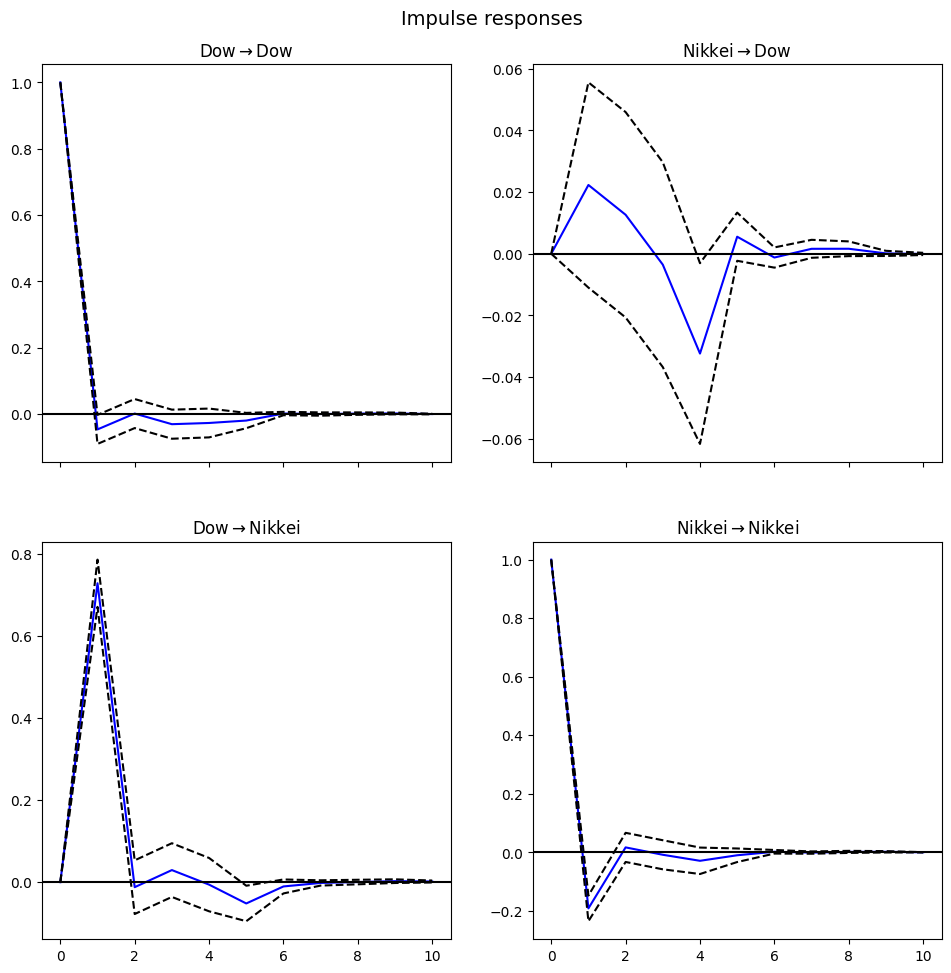

In [39]:
# インパルス応答関数の計算
irf = var_result.irf(10)  # 10期間のインパルス応答関数を計算
irf.plot(orth=False)  # インパルス応答関数のプロット
plt.show()

## 15章の練習問題

In [ ]:
# p=1としたVARとグレンジャーの因果性検定
# ラグ変数の作成
df_data_lagged <- as.data.frame(ts_data) # tsオブジェクトをdfに変換
df_data_lagged <- df_data_lagged %>% # データフレームに対してmutateを使用してラグ変数を作成
  mutate(
    lag1_dow = lag(Dow, 1),
    lag1_nikkei = lag(Nikkei, 1),
  )
df_data_lagged <- na.omit(df_data_lagged) # 欠損値を含む行を除去
ts_data_lagged <- ts( # データフレームを再びtsオブジェクトに変換
  df_data_lagged,
  start = c(start_year, start_month),
  frequency = 12
)
head(ts_data_lagged)# データの確認

# 回帰分析の実行
model <- lm(
  Nikkei ~ lag1_nikkei + lag1_dow,
  data = ts_data_lagged
)
robust_se <- coeftest(
  model,
  vcov = vcovHC(
    model,
    type = "HC1"
  )
) # ロバスト標準誤差
summary(model)
print(robust_se)
# F検定
f_test_result <- linearHypothesis(
  model,
  "lag1_dow = 0"
)
print(f_test_result)

# 回帰分析の実行
model <- lm(
  Dow ~ lag1_nikkei + lag1_dow,
  data = ts_data_lagged
)
robust_se <- coeftest(
  model,
  vcov = vcovHC(
    model,
    type = "HC1"
  )
) # ロバスト標準誤差
summary(model)
print(robust_se)
# F検定
f_test_result <- linearHypothesis(
  model,
  "lag1_nikkei = 0"
)
print(f_test_result)

# VARモデルの推定
var_model <- VAR(
  ts_data,
  p = 1,
  type = "const"
)
summary(var_model)
# インパルス応答関数の作成
irf_result <- irf(
  var_model,
  impulse = c("Dow", "Nikkei"),
  response = c("Dow", "Nikkei"),
  n.ahead = 10, # 予測期間
  boot = TRUE # ブートストラップ法
)

par(
  mfrow = c(2, 2)
) # グラフィックスウィンドウを2行2列に分割
# DowからDowへのショックに対するインパルス応答関数のプロット
plot(
  irf_result$irf$Dow[, "Dow"],
  type = "l",
  main = "Impulse from Dow to Dow",
  xlab = "Periods",
  ylab = "Response"
)
lines(
  irf_result$Lower$Dow[, "Dow"],
  col = "red",
  lty = 2
)
lines(
  irf_result$Upper$Dow[, "Dow"],
  col = "red",
  lty = 2
)
# DowからNikkeiへのショックに対するインパルス応答関数のプロット
plot(
  irf_result$irf$Dow[, "Nikkei"],
  type = "l",
  main = "Impulse from Dow to Nikkei",
  xlab = "Periods",
  ylab = "Response"
)
lines(
  irf_result$Lower$Dow[, "Nikkei"],
  col = "red",
  lty = 2
)
lines(
  irf_result$Upper$Dow[, "Nikkei"],
  col = "red",
  lty = 2
)
# NikkeiからDowへのショックに対するインパルス応答関数のプロット
plot(
  irf_result$irf$Nikkei[, "Dow"],
  type = "l",
  main = "Impulse from Nikkei to Dow",
  xlab = "Periods",
  ylab = "Response"
)
lines(
  irf_result$Lower$Nikkei[, "Dow"],
  col = "red",
  lty = 2
)
lines(
  irf_result$Upper$Nikkei[, "Dow"],
  col = "red",
  lty = 2
)
# NikkeiからNikkeiへのショックに対するインパルス応答関数のプロット
plot(
  irf_result$irf$Nikkei[, "Nikkei"],
  type = "l",
  main = "Impulse from Nikkei to Nikkei",
  xlab = "Periods",
  ylab = "Response"
)
lines(
  irf_result$Lower$Nikkei[, "Nikkei"],
  col = "red",
  lty = 2
)
lines(
  irf_result$Upper$Nikkei[, "Nikkei"],
  col = "red",
  lty = 2
)